In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

In [2]:
url = 'https://raw.githubusercontent.com/alexandermaxim8/Tugas-Besar-Pemod-Kel11/main/evchargedata.csv'
df_charge = pd.read_csv(url, encoding = 'unicode_escape')
url = 'https://raw.githubusercontent.com/alexandermaxim8/Tugas-Besar-Pemod-Kel11/main/clusters.csv'
df_cluster = pd.read_csv(url, encoding = 'unicode_escape')

In [3]:
df_charge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76698 entries, 0 to 76697
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ï»¿ParticipantID        76698 non-null  object
 1   BatteryChargeStartDate  76698 non-null  object
 2   BatteryChargeStopDate   76698 non-null  object
 3   Starting SoC (of 12)    76698 non-null  int64 
 4   Ending SoC (of 12)      76698 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.9+ MB


In [4]:
df_charge['BatteryChargeStartDate'] = pd.to_datetime(df_charge['BatteryChargeStartDate'])
df_charge['BatteryChargeStopDate'] = pd.to_datetime(df_charge['BatteryChargeStopDate'])
df_charge['Duration'] = (df_charge['BatteryChargeStopDate']-df_charge['BatteryChargeStartDate'])/np.timedelta64(1,'h')
df_charge['MidTime'] = df_charge['BatteryChargeStartDate']+(df_charge['BatteryChargeStopDate']-df_charge['BatteryChargeStartDate'])/2
df_charge['DayofWeek'] = df_charge['MidTime'].dt.dayofweek
df_charge['HourofDay'] = df_charge['MidTime'].dt.hour
df_charge = df_charge.drop(['BatteryChargeStartDate', 'BatteryChargeStopDate', 'MidTime'], axis=1)

In [5]:
df_charge

,ï»¿ParticipantID,Starting SoC (of 12),Ending SoC (of 12),Duration,DayofWeek,HourofDay
0,GC10,1,11,1.000000,6,16
1,GC10,2,11,0.666667,6,18
2,GC10,4,12,7.783333,0,12
3,GC10,5,8,2.183333,1,8
4,GC10,4,4,0.050000,1,15
...,...,...,...,...,...,...
76693,SS206,4,10,2.500000,5,19
76694,ST1074,7,12,4.366667,6,17
76695,ST1062,8,12,3.433333,6,7
76696,BL05,10,12,2.300000,5,23


In [6]:
SS2_index = df_charge.index[df_charge['ï»¿ParticipantID'].astype(str).str.contains('SS2')]
df_charge['ï»¿ParticipantID'] = df_charge['ï»¿ParticipantID'].astype(str).str.replace('\d', '')
df_charge = df_charge.rename({'ï»¿ParticipantID': 'ID'}, axis=1)
df_cluster = df_cluster.rename({'ï»¿Prefix': 'ID'}, axis=1)
df_alldata = pd.merge(df_charge, df_cluster, on=['ID'], how='outer')
df_alldata.loc[SS2_index, 'ID'] = 'SS2'
df_alldata = df_alldata.drop(['Name', 'MC_ID', 'DNO', 'MCInstallationDate'], axis=1)
df_alldata = df_alldata.dropna()
df_alldata.reset_index(drop=True, inplace=True)
df_alldata_noKmeans = df_alldata
df_alldata

C:\Users\Asus\AppData\Local\Temp\ipykernel_40532\2230124627.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_charge['ï»¿ParticipantID'] = df_charge['ï»¿ParticipantID'].astype(str).str.replace('\d', '')


,ID,Starting SoC (of 12),Ending SoC (of 12),Duration,DayofWeek,HourofDay,NumberOfHousesOnFeeder,CableRating,EVClusterSize
0,GC,1.0,11.0,1.000000,6.0,16.0,57.0,350.0,9.0
1,GC,2.0,11.0,0.666667,6.0,18.0,57.0,350.0,9.0
2,GC,4.0,12.0,7.783333,0.0,12.0,57.0,350.0,9.0
3,GC,5.0,8.0,2.183333,1.0,8.0,57.0,350.0,9.0
4,GC,4.0,4.0,0.050000,1.0,15.0,57.0,350.0,9.0
...,...,...,...,...,...,...,...,...,...
29144,CC,6.0,12.0,4.100000,6.0,22.0,149.0,335.0,8.0
29145,CC,3.0,12.0,5.200000,1.0,23.0,149.0,335.0,8.0
29146,CC,7.0,12.0,4.016667,6.0,18.0,149.0,335.0,8.0
29147,CC,6.0,12.0,4.050000,1.0,18.0,149.0,335.0,8.0


In [7]:
df_alldata.shape[0]

29149

In [8]:
df_alldata_noKmeans['Cluster'] = df_alldata_noKmeans['Duration'].apply(lambda x: 0 if x <= 2 else 1 if x>2 and x<6 else 2)
c = np.zeros(3)
c_old = np.zeros(3)
c[0] = np.random.randint(0, 2)
c[1] = np.random.randint(2, 6)
while c[1]==c[0]:
  c[1] = np.random.randint(2, 6)
c[2] = np.random.randint(6, 12)
while c[2]==c[1] or c[2]==c[0]:
  c[2] = np.random.randint(6, 12)

d = np.zeros(3)

while True:
  i=0
  for i in range(df_alldata.shape[0]):
    d[0] = abs(df_alldata.iloc[i]['Duration']-c[0])
    d[1] = abs(df_alldata.iloc[i]['Duration']-c[1])
    d[2] = abs(df_alldata.iloc[i]['Duration']-c[2])
    df_alldata.at[i, 'Cluster'] = np.argmin(d) + 1
  #   if (i%1000) == 0:
  #     print(i)
  # print(df_alldata.shape[0])
  c_old[0] = c[0]; c_old[1] = c[1]; c_old[2] = c[2]
  c[0] = df_alldata[df_alldata['Cluster'] == 1]['Duration'].mean()
  c[1] = df_alldata[df_alldata['Cluster'] == 2]['Duration'].mean()
  c[2] = df_alldata[df_alldata['Cluster'] == 3]['Duration'].mean()
  print(str(c[0])+" "+str(c[1])+" "+str(c[2]))
  # print(df_alldata.shape[0])
  if c[0]-c_old[0]<0.01 and c[1]-c_old[1]<0.01 and c[2]-c_old[2]<0.01:
    break;
df_alldata

0.9119469795740983 3.9953186375095275 7.918483816013628
1.1145994261752372 3.9767381148667216 6.8124190390119
1.152686556485655 3.8283346261024453 6.376291211357057
1.1294489315772878 3.6967114012815867 6.1669483782549115


,ID,Starting SoC (of 12),Ending SoC (of 12),Duration,DayofWeek,HourofDay,NumberOfHousesOnFeeder,CableRating,EVClusterSize,Cluster
0,GC,1.0,11.0,1.000000,6.0,16.0,57.0,350.0,9.0,1
1,GC,2.0,11.0,0.666667,6.0,18.0,57.0,350.0,9.0,1
2,GC,4.0,12.0,7.783333,0.0,12.0,57.0,350.0,9.0,3
3,GC,5.0,8.0,2.183333,1.0,8.0,57.0,350.0,9.0,1
4,GC,4.0,4.0,0.050000,1.0,15.0,57.0,350.0,9.0,1
...,...,...,...,...,...,...,...,...,...,...
29144,CC,6.0,12.0,4.100000,6.0,22.0,149.0,335.0,8.0,2
29145,CC,3.0,12.0,5.200000,1.0,23.0,149.0,335.0,8.0,3
29146,CC,7.0,12.0,4.016667,6.0,18.0,149.0,335.0,8.0,2
29147,CC,6.0,12.0,4.050000,1.0,18.0,149.0,335.0,8.0,2


In [9]:
df_alldata = pd.get_dummies(data=df_alldata, columns=['Cluster'])
df_alldata_noKmeans = pd.get_dummies(data=df_alldata_noKmeans, columns=['Cluster'])
print(df_alldata)
print(df_alldata_noKmeans)

       ID  Starting SoC (of 12)  Ending SoC (of 12)  Duration  DayofWeek  \
0      GC                   1.0                11.0  1.000000        6.0   
1      GC                   2.0                11.0  0.666667        6.0   
2      GC                   4.0                12.0  7.783333        0.0   
3      GC                   5.0                 8.0  2.183333        1.0   
4      GC                   4.0                 4.0  0.050000        1.0   
...    ..                   ...                 ...       ...        ...   
29144  CC                   6.0                12.0  4.100000        6.0   
29145  CC                   3.0                12.0  5.200000        1.0   
29146  CC                   7.0                12.0  4.016667        6.0   
29147  CC                   6.0                12.0  4.050000        1.0   
29148  CC                   3.0                10.0  2.966667        3.0   

       HourofDay  NumberOfHousesOnFeeder  CableRating  EVClusterSize  \
0           16.

In [10]:
def PCA(X):
    X = (X - np.mean(X, axis=0))/np.std(X, axis=0)
    n_components = 4
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_components)
    return np.array(pca.fit_transform(X))

In [11]:
def stdnorm(X):
    return (X - np.mean(X, axis=0))/np.std(X, axis=0)

In [12]:
X = df_alldata[['Starting SoC (of 12)', 'Ending SoC (of 12)', 'DayofWeek', 'HourofDay', 'NumberOfHousesOnFeeder', 'CableRating', 'EVClusterSize']]
X_noKmeans = df_alldata[['Starting SoC (of 12)', 'Ending SoC (of 12)', 'DayofWeek', 'HourofDay', 'NumberOfHousesOnFeeder', 'CableRating', 'EVClusterSize']]
y = df_alldata[['Cluster_1', 'Cluster_2', 'Cluster_3']]
y_noKmeans = df_alldata[['Cluster_1', 'Cluster_2', 'Cluster_3']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_noKmeans, X_test_noKmeans, y_train_noKmeans, y_test_noKmeans = train_test_split(X_noKmeans, y_noKmeans, test_size=0.2)
X_train = X_train.values
X_train_noKmeans = X_train_noKmeans.values
y_train = y_train.values
y_train_noKmeans = y_train_noKmeans.values
X_test = X_test.values
X_test_noKmeans = X_test_noKmeans.values
y_test = y_test.values
y_test_noKmeans = y_test_noKmeans.values
newX_train_noPCA = stdnorm(X_train)
newX_test_noPCA = stdnorm(X_test)
newX_train = PCA(X_train)
newX_test = PCA(X_test)
newX_train_noKmeans = PCA(X_train_noKmeans)
newX_test_noKmeans = PCA(X_test_noKmeans)

**MODELLING**

Activation Function

In [13]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    expX = np.exp(x)
    return expX/np.sum(expX, axis = 0)
    #exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    #return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

In [14]:
def derivative_relu(x):
    return np.array(x > 0, dtype = np.float32)

Initialize Parameters

In [15]:
#n_x = 7
#n_h = 6
#n_y = 3
def initialize_parameters(n_x, n_h, n_y):
   w1 = np.random.randn(n_h, n_x)
   b1 = np.random.randn(n_h, 1)

   w2 = np.random.randn(n_y, n_h)
   b2 = np.random.randn(n_y, 1)

   parameters = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2
    }

   return parameters

Forward Propagation

In [16]:
def forward_propagation(x, parameters):

  w1 = parameters['w1']
  b1 = parameters['b1']
  w2 = parameters['w2']
  b2 = parameters['b2']

    
#   print(w1.shape)
#   print(x.shape)
#   print(b1.shape)
  z1 = np.dot(w1, x) + b1
  a1 = relu(z1)
#   print(w2.shape)
#   print(a1.shape)
#   print(b2.shape)
  z2 = np.dot(w2, a1) + b2
  a2 = softmax(z2)
#   print(a2.shape)

  forward_cache = {
       "z1": z1,
       "a1": a1,
       "z2": z2,
       "a2": a2
  }

  return forward_cache

#Cost Function

In [17]:
def cost_function(a2, y):
  m = y.shape[1]
#   print(m)
  #cost = -(1/m)*np.sum(y*np.log(a2))

  cost = -(1/m)*np.sum(np.sum(y*np.log(a2), 1), 0)
  return cost

# Backpropagation

In [18]:
def back_prop(x, y, parameters, forward_cache):

  w1 = parameters['w1']
  b1 = parameters['b1']
  w2 = parameters['w2']
  b2 = parameters['b2']

  a1 = forward_cache['a1']
  a2 = forward_cache['a2']

  m = x.shape[1]

  dz2 = (a2 - y)
  dw2 = (1/m)*np.dot(dz2, a1.T)
  db2 = (1/m)*np.sum(dz2, axis=1, keepdims=True)

  dz1 = (1/m)*np.dot(w2.T, dz2)*derivative_relu(a1)
  dw1 = (1/m)*np.dot(dz1, x.T)
  db1 = (1/m)*np.sum(dz1, axis=1, keepdims=True)

  gradients = {
      "dw1" : dw1,
      "db1" : db1,
      "dw2" : dw2,
      "db2" : db2
  }

  return gradients

#Update Parameters

In [19]:
def update_parameters(parameters, gradients, learning_rate):
  w1 = parameters['w1']
  b1 = parameters['b1']
  w2 = parameters['w2']
  b2 = parameters['b2']

  dw1 = gradients['dw1']
  db1 = gradients['db1']
  dw2 = gradients['dw2']
  db2 = gradients['db2']

#   print(b2.shape)
#   print(db2.shape)
  w1 = w1 - learning_rate*dw1
  b1 = b1 - learning_rate*db1
  w2 = w2 - learning_rate*dw2
  b2 = b2 - learning_rate*db2

  parameters = {
      "w1" : w1,
      "b1" : b1,
      "w2" : w2,
      "b2" : b2
  }

  return parameters


In [20]:
def model(x, y, n_h, learning_rate, iterations):

  n_x = x.shape[0]
  n_y = y.shape[0]

  cost_list = []

  parameters = initialize_parameters(n_x, n_h, n_y)

  for i in range(iterations+1):
    forward_cache = forward_propagation(x, parameters)

    cost = cost_function(forward_cache['a2'], y)

    gradients = back_prop(x, y, parameters, forward_cache)
    

    parameters = update_parameters(parameters, gradients, learning_rate)

    cost_list.append(cost)

    if(i%(iterations/10) == 0):
      print("Cost after", i, "iterations is :", cost)

  return parameters, cost_list

In [21]:
iterations = 100
n_h = 25
learning_rate = 0.1
Parameters_train, Cost_list_train = model(np.transpose(newX_train), np.transpose(y_train), n_h , learning_rate = learning_rate, iterations = iterations)
print("==============================================")
arameters_test, Cost_list_test = model(np.transpose(newX_test), np.transpose(y_test), n_h , learning_rate = learning_rate, iterations = iterations)

Cost after 0 iterations is : 5.438417599682821
Cost after 10 iterations is : 2.7906042988486717
Cost after 20 iterations is : 2.1651100673739307
Cost after 30 iterations is : 1.73145819678566
Cost after 40 iterations is : 1.3780779912144872
Cost after 50 iterations is : 1.167004086779068
Cost after 60 iterations is : 1.0840099829709868
Cost after 70 iterations is : 1.0409603097824829
Cost after 80 iterations is : 1.0117790454631423
Cost after 90 iterations is : 0.9893845469144327
Cost after 100 iterations is : 0.9710709569877739
Cost after 0 iterations is : 7.290505495825557
Cost after 10 iterations is : 3.7535320638854444
Cost after 20 iterations is : 2.4079026351594734
Cost after 30 iterations is : 1.7631352651110128
Cost after 40 iterations is : 1.508897527989354
Cost after 50 iterations is : 1.3395056270986094
Cost after 60 iterations is : 1.2152915516241316
Cost after 70 iterations is : 1.1269261846239476
Cost after 80 iterations is : 1.0703777107421693
Cost after 90 iterations is

In [22]:
Parameters_train_noKmeans, Cost_list_train_noKmeans = model(np.transpose(newX_train_noKmeans), np.transpose(y_train_noKmeans), n_h , learning_rate = learning_rate, iterations = iterations)
print("==============================================")
Parameters_test_noKmeans, Cost_list_test_noKmeans = model(np.transpose(newX_test_noKmeans), np.transpose(y_test_noKmeans), n_h , learning_rate = learning_rate, iterations = iterations)

Cost after 0 iterations is : 4.986354339387865
Cost after 10 iterations is : 3.1064284041117274
Cost after 20 iterations is : 2.212058430433368
Cost after 30 iterations is : 1.6874525158298423
Cost after 40 iterations is : 1.4386378452422781
Cost after 50 iterations is : 1.3148727141270962
Cost after 60 iterations is : 1.2312655229733291
Cost after 70 iterations is : 1.167128812881602
Cost after 80 iterations is : 1.116782079295865
Cost after 90 iterations is : 1.0770340698264378
Cost after 100 iterations is : 1.0454601902680996
Cost after 0 iterations is : 4.030448685922098
Cost after 10 iterations is : 1.951855072843372
Cost after 20 iterations is : 1.4222171853868475
Cost after 30 iterations is : 1.2631145092210876
Cost after 40 iterations is : 1.1792068258062407
Cost after 50 iterations is : 1.128319203642265
Cost after 60 iterations is : 1.0924479835115217
Cost after 70 iterations is : 1.0648743691352986
Cost after 80 iterations is : 1.0426018518603646
Cost after 90 iterations is 

In [23]:
Parameters_train_noPCA, Cost_list_train_noPCA = model(np.transpose(newX_train_noPCA), np.transpose(y_train), n_h , learning_rate = learning_rate, iterations = iterations)
print("==============================================")
arameters_test_noPCA, Cost_list_test_noPCA = model(np.transpose(newX_test_noPCA), np.transpose(y_test), n_h , learning_rate = learning_rate, iterations = iterations)

Cost after 0 iterations is : 8.895266932508928
Cost after 10 iterations is : 2.199362443324811
Cost after 20 iterations is : 1.5729128109853006
Cost after 30 iterations is : 1.321831510393739
Cost after 40 iterations is : 1.1576465092989072
Cost after 50 iterations is : 1.0443138533476601
Cost after 60 iterations is : 0.9619096303050726
Cost after 70 iterations is : 0.8983530027598408
Cost after 80 iterations is : 0.8474413239356989
Cost after 90 iterations is : 0.805635112718805
Cost after 100 iterations is : 0.7706954935686323
Cost after 0 iterations is : 6.676348986210027
Cost after 10 iterations is : 2.6106640204928624
Cost after 20 iterations is : 2.0390158271482783
Cost after 30 iterations is : 1.739040627830859
Cost after 40 iterations is : 1.5170445663232761
Cost after 50 iterations is : 1.3398614012958419
Cost after 60 iterations is : 1.1946896836772778
Cost after 70 iterations is : 1.0752431033873664
Cost after 80 iterations is : 0.9775819413446533
Cost after 90 iterations is

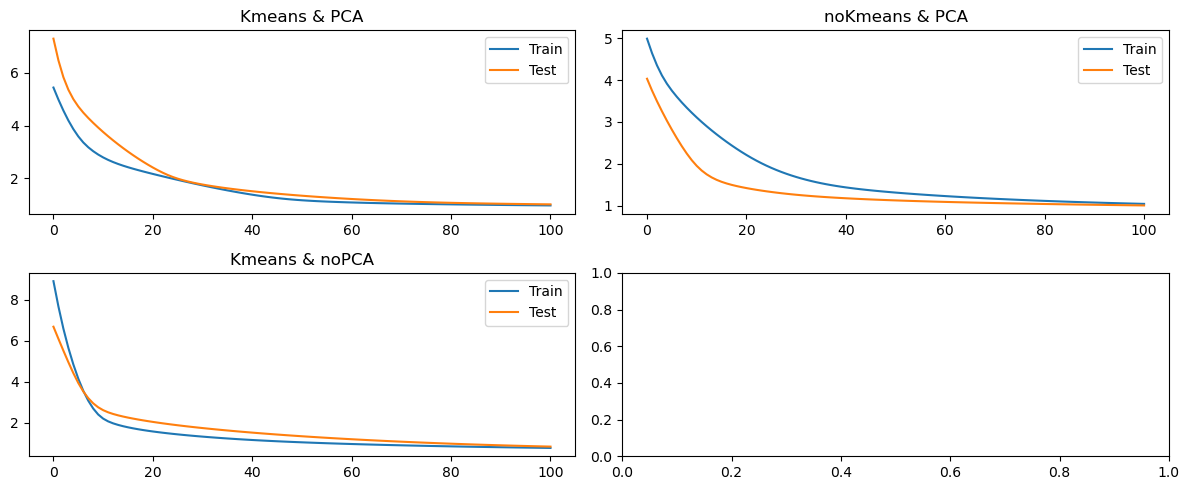

In [24]:
fig, ax = plt.subplots(2,2, figsize=(12,5))

t = np.arange(0, iterations+1)

ax[0, 0].plot(t, Cost_list_train, label='Train')
ax[0, 0].plot(t, Cost_list_test, label='Test')
ax[0, 0].set_title('Kmeans & PCA')
ax[0, 0].legend()
ax[0, 1].plot(t, Cost_list_train_noKmeans, label='Train')
ax[0, 1].plot(t, Cost_list_test_noKmeans, label='Test')
ax[0, 1].set_title('noKmeans & PCA')
ax[0, 1].legend()
ax[1, 0].plot(t, Cost_list_train_noPCA, label='Train')
ax[1, 0].plot(t, Cost_list_test_noPCA, label='Test')
ax[1, 0].set_title('Kmeans & noPCA')
ax[1, 0].legend()
plt.tight_layout()
plt.show()

In [25]:
forward_cache = forward_propagation(np.transpose(newX_test), Parameters_train)
predict = forward_cache['a2']
print(predict)
print("==============================================")
forward_cache = forward_propagation(np.transpose(newX_test_noKmeans), Parameters_train_noKmeans)
predict_noKmeans = forward_cache['a2']
print(predict_noKmeans)
print("==============================================")
forward_cache = forward_propagation(np.transpose(newX_test_noPCA), Parameters_train_noPCA)
predict_noPCA = forward_cache['a2']
print(predict_noPCA)

[[9.69182351e-01 8.33365545e-02 9.99999932e-01 ... 1.28600212e-01
  2.68777591e-01 8.51495421e-01]
 [3.00054189e-02 3.25690056e-01 6.38355197e-08 ... 8.56503867e-01
  6.90865790e-01 4.61309588e-02]
 [8.12230370e-04 5.90973389e-01 3.83158531e-09 ... 1.48959216e-02
  4.03566195e-02 1.02373620e-01]]
[[7.73025126e-01 2.97418388e-01 6.69906226e-01 ... 8.10694531e-01
  4.42651919e-01 4.17537597e-01]
 [1.14208756e-02 5.57506299e-01 2.98161494e-01 ... 8.55451907e-02
  5.57347249e-01 2.30061359e-01]
 [2.15553998e-01 1.45075313e-01 3.19322803e-02 ... 1.03760278e-01
  8.31428202e-07 3.52401045e-01]]
[[8.81905189e-01 7.61067127e-04 9.99999984e-01 ... 9.10512715e-01
  5.49104955e-01 3.65868604e-01]
 [1.18042463e-01 6.23003823e-01 1.58606524e-08 ... 8.90598050e-02
  4.50801434e-01 5.08257794e-01]
 [5.23482364e-05 3.76235110e-01 4.88950254e-16 ... 4.27480427e-04
  9.36117498e-05 1.25873602e-01]]


In [26]:
predict = (predict > 0.5).astype(int)
print(predict)
print("==============================================")
predict_noKmeans = (predict_noKmeans > 0.5).astype(int)
print(predict_noKmeans)
print("==============================================")
predict_noPCA = (predict_noPCA > 0.5).astype(int)
print(predict_noPCA)

[[1 0 1 ... 0 0 1]
 [0 0 0 ... 1 1 0]
 [0 1 0 ... 0 0 0]]
[[1 0 1 ... 1 0 0]
 [0 1 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
[[1 0 1 ... 1 1 0]
 [0 1 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


In [27]:
predict_vect = np.argmax(predict, axis=0)
y_test_vect = np.argmax(y_test, axis=1)
predict_vect_noKmeans = np.argmax(predict_noKmeans, axis=0)
y_test_vect_noKmeans = np.argmax(y_test_noKmeans, axis=1)
predict_vect_noPCA = np.argmax(predict_noPCA, axis=0)

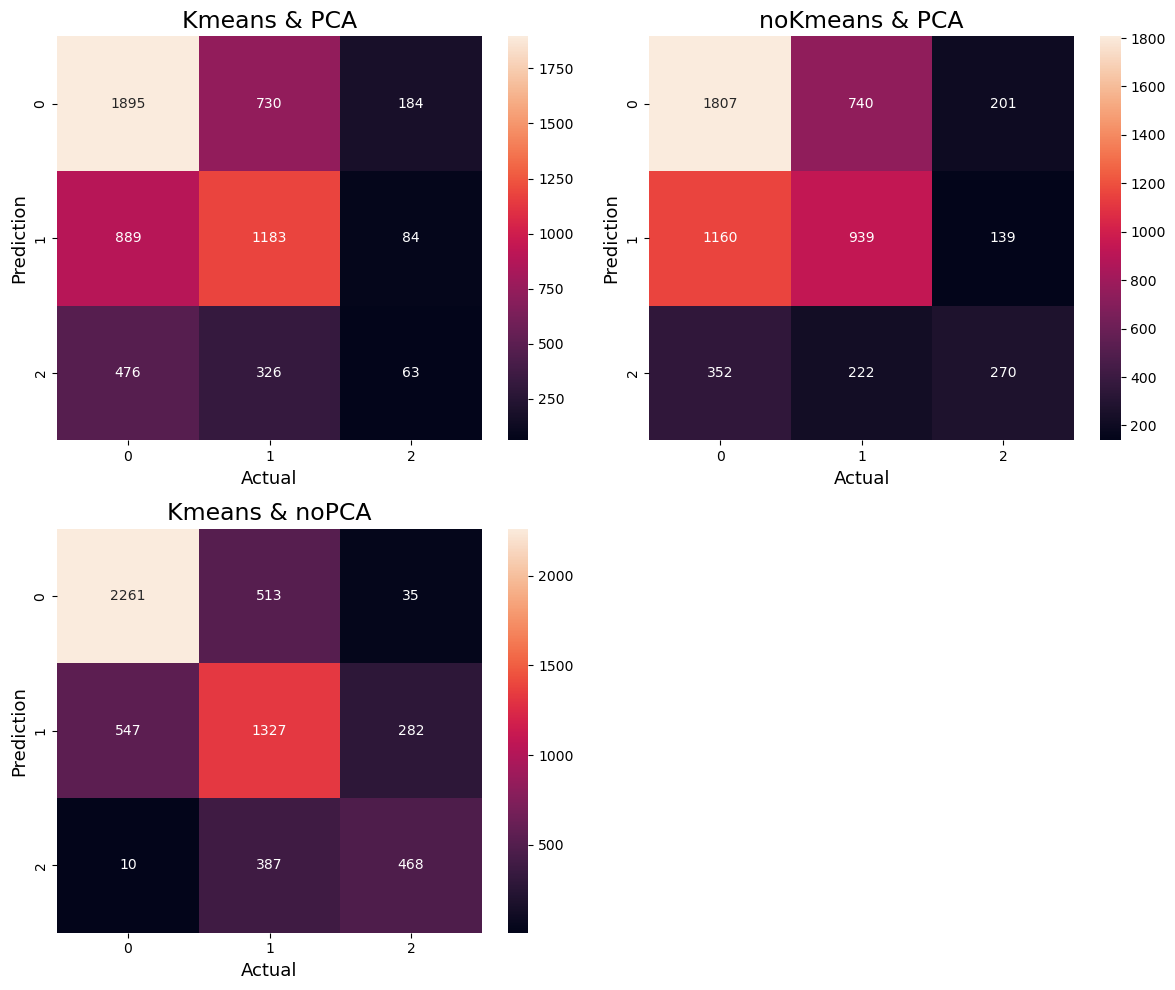

In [28]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test_vect, predict_vect)
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Kmeans & PCA',fontsize=17)

plt.subplot(2, 2, 2)
cm = confusion_matrix(y_test_vect_noKmeans, predict_vect_noKmeans)
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('noKmeans & PCA',fontsize=17)

plt.subplot(2, 2, 3)
cm = confusion_matrix(y_test_vect, predict_vect_noPCA)
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Kmeans & noPCA',fontsize=17)

plt.tight_layout()
plt.show()